In [ ]:
!pip install kagglehub

In [ ]:
!pip install opencv-python-headless Pillow numpy

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

## **Огляд** **бібліотек**

**OpenCV (Open Source Computer Vision Library)**

OpenCV — це одна з найпоширеніших бібліотек для обробки зображень та комп'ютерного зору. Вона підтримує безліч мов програмування, включаючи Python, і надає близько 2500 алгоритмів для різних завдань, таких як розпізнавання облич, виявлення об'єктів та сегментація зображень.

**Pillow (Python Imaging Library, PIL)**

Pillow є форком бібліотеки PIL і забезпечує прості засоби для роботи із зображеннями: відкриття, обробка та збереження в різних форматах. Вона дозволяє виконувати операції, такі як зміна розміру, обрізка, поворот та фільтрація зображень. Pillow часто використовується для уніфікації фото й аналізу їхніх властивостей.

**NumPy**

NumPy — це бібліотека для роботи з багатовимірними масивами та виконання математичних операцій. В обробці зображень вона використовується для маніпуляції пікселями, маскування значень пікселів та обрізання зображень. NumPy є основою для багатьох інших бібліотек, включаючи OpenCV та Pillow.


In [ ]:
import kagglehub

path = kagglehub.dataset_download("rameshrpatil/flying-object-dataset")

print("Path to dataset files:", path)

100%|██████████| 676M/676M [00:27<00:00, 25.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/rameshrpatil/flying-object-dataset/versions/1


In [ ]:
import shutil

src_path = "/root/.cache/kagglehub/datasets/rameshrpatil/flying-object-dataset/versions/1"
dst_path = "/content/drive/MyDrive/Flying object detection system"

shutil.move(src_path, dst_path)

print(f"Dataset переміщено в {dst_path}")

Dataset переміщено в /content/drive/MyDrive/Flying object detection system


In [3]:
class ImageLoader:
    def __init__(self, folder_path):
        self.folder_path = folder_path
        self.image_files = self._get_image_files()

    def _get_image_files(self):
        valid_extensions = (".png", ".jpg", ".jpeg", ".bmp")
        return [f for f in os.listdir(self.folder_path) if f.lower().endswith(valid_extensions)]

    def load_images(self):
        images = []
        for img_file in self.image_files:
            img_path = os.path.join(self.folder_path, img_file)
            img = cv2.imread(img_path)
            if img is not None:
                images.append((img_file, img))
        return images

    def show_image(self, img_name):
        img_path = os.path.join(self.folder_path, img_name)

        img_cv2 = cv2.imread(img_path)
        img_cv2 = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)
        img_pil = Image.open(img_path)

        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].imshow(img_cv2)
        axes[0].set_title(f"OpenCV: {img_name}")
        axes[0].axis("off")

        axes[1].imshow(img_pil)
        axes[1].set_title(f"PIL: {img_name}")
        axes[1].axis("off")

        plt.show()

In [9]:
folder_path = "/content/drive/MyDrive/Flying object detection system/1/UAV_Dataset/Bird"

loader = ImageLoader(folder_path)

images = loader.load_images()
print(f"Знайдено {len(images)} зображень")


Знайдено 1007 зображень


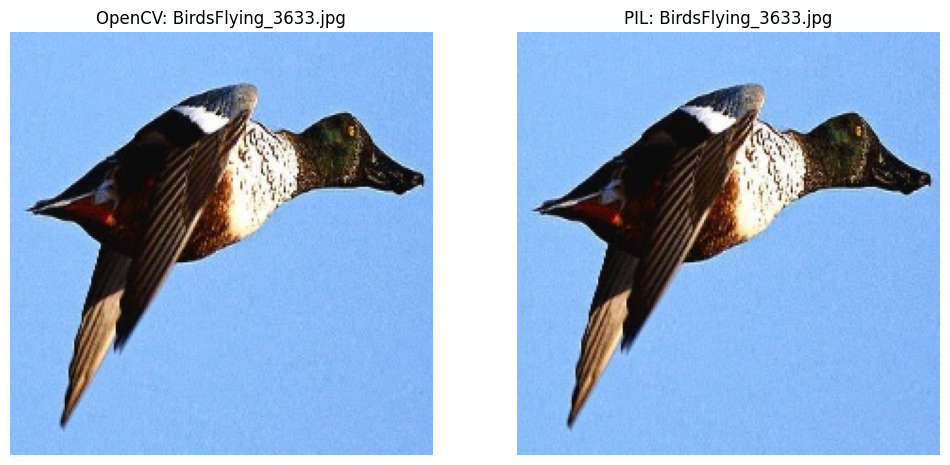

In [10]:
loader.show_image(images[0][0])

In [11]:
class ImageProcessor:
    def __init__(self, images):
        """
        Клас для аналізу та обробки зображень.
        :param images: список кортежів (ім'я_файлу, зображення)
        """
        self.image_cache = {name: img for name, img in images}

    def get_image_info(self, img_name):
        """ Виводить характеристики зображення. """
        img = self.image_cache.get(img_name, None)
        if img is None:
            print(f"Помилка: неможливо знайти {img_name}")
            return

        height, width, channels = img.shape
        print(f"Файл: {img_name}")
        print(f"Розмір: {width}x{height}")
        print(f"Канали: {channels}")

    def plot_histogram(self, img_name):
        """ Побудова гістограми яскравості. """
        img = self.image_cache.get(img_name, None)
        if img is None:
            print(f"Помилка: неможливо знайти {img_name}")
            return

        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Перетворення в градації сірого
        plt.figure(figsize=(8, 6))
        plt.hist(gray_img.ravel(), bins=256, range=[0, 256], color='black', alpha=0.7)
        plt.title(f"Гістограма яскравості: {img_name}")
        plt.xlabel("Яскравість")
        plt.ylabel("Кількість пікселів")
        plt.show()

    def enhance_contrast_gray(self, img_name, method="equalization"):
        """
        Покращення контрастності для сірого зображення.
        :param img_name: ім'я файлу зображення
        :param method: "equalization" або "clahe"
        """
        img = self.image_cache.get(img_name, None)
        if img is None:
            print(f"Помилка: неможливо знайти {img_name}")
            return

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        if method == "equalization":
            enhanced = cv2.equalizeHist(gray)
            title = "Еквалізація гістограми (сіре зображення)"
        elif method == "clahe":
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            enhanced = clahe.apply(gray)
            title = "CLAHE (сіре зображення)"
        else:
            print("Невідомий метод покращення контрастності")
            return

        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].imshow(gray, cmap="gray")
        axes[0].set_title(f"Оригінальне: {img_name}")
        axes[0].axis("off")

        axes[1].imshow(enhanced, cmap="gray")
        axes[1].set_title(title)
        axes[1].axis("off")

        plt.show()

    def enhance_contrast_color(self, img_name, method="equalization"):
        """
        Покращення контрастності для кольорового зображення.
        :param img_name: ім'я файлу зображення
        :param method: "equalization" або "clahe"
        """
        img = self.image_cache.get(img_name, None)
        if img is None:
            print(f"Помилка: неможливо знайти {img_name}")
            return

        img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(img_lab)

        if method == "equalization":
            l = cv2.equalizeHist(l)
            title = "Еквалізація гістограми (кольорове зображення)"
        elif method == "clahe":
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            l = clahe.apply(l)
            title = "CLAHE (кольорове зображення)"
        else:
            print("Невідомий метод покращення контрастності")
            return

        enhanced_lab = cv2.merge((l, a, b))
        enhanced_img = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)

        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axes[0].set_title(f"Оригінальне: {img_name}")
        axes[0].axis("off")

        axes[1].imshow(cv2.cvtColor(enhanced_img, cv2.COLOR_BGR2RGB))
        axes[1].set_title(title)
        axes[1].axis("off")

        plt.show()

Файл: BirdsFlying_3633.jpg
Розмір: 224x224
Канали: 3


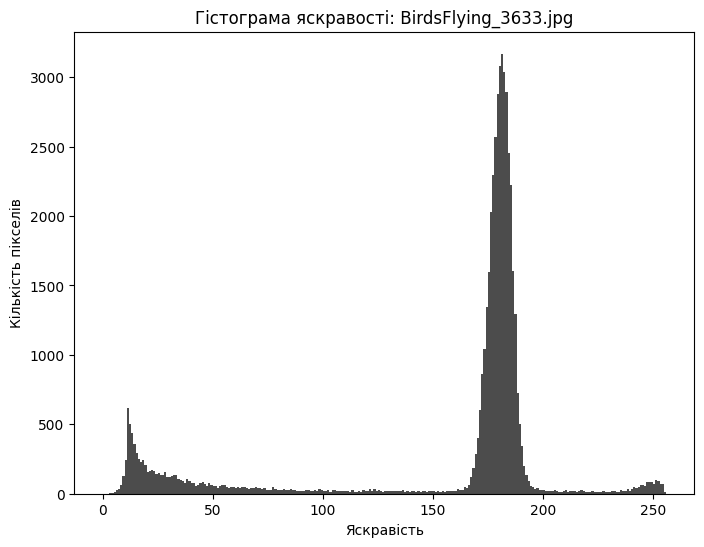

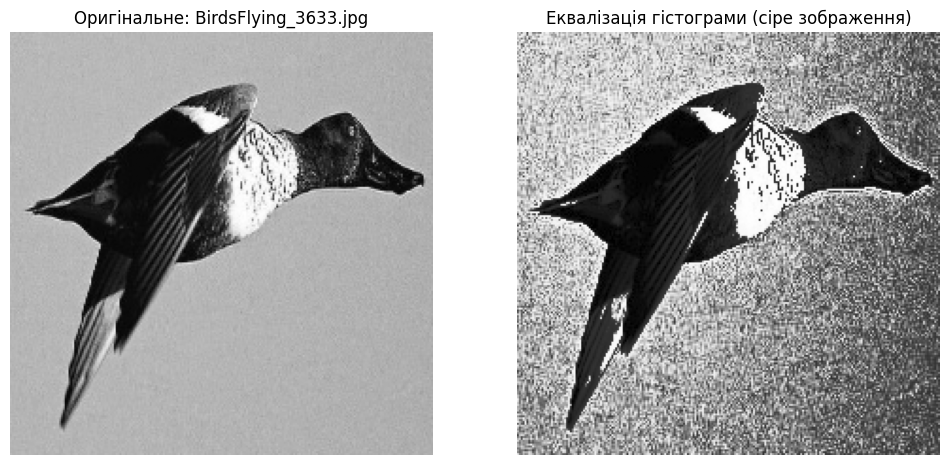

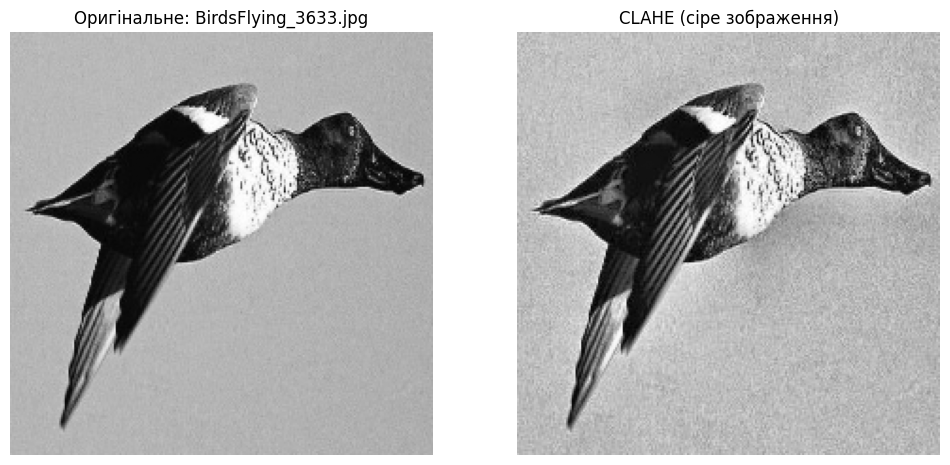

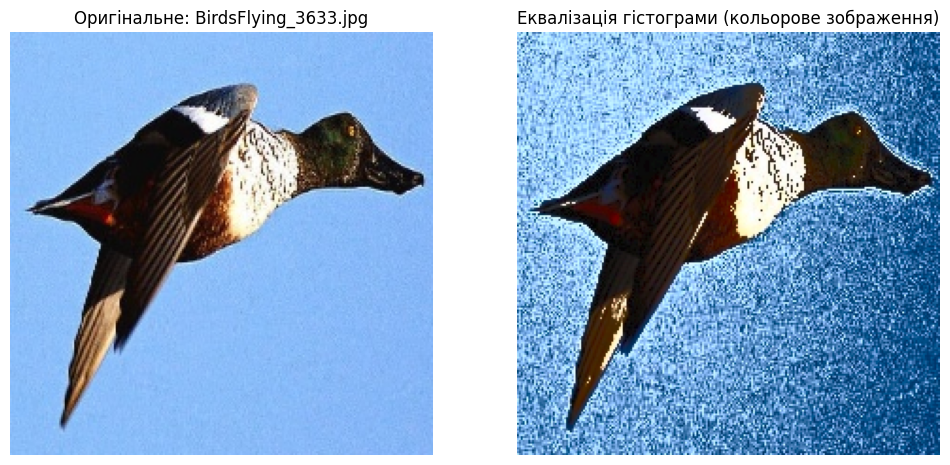

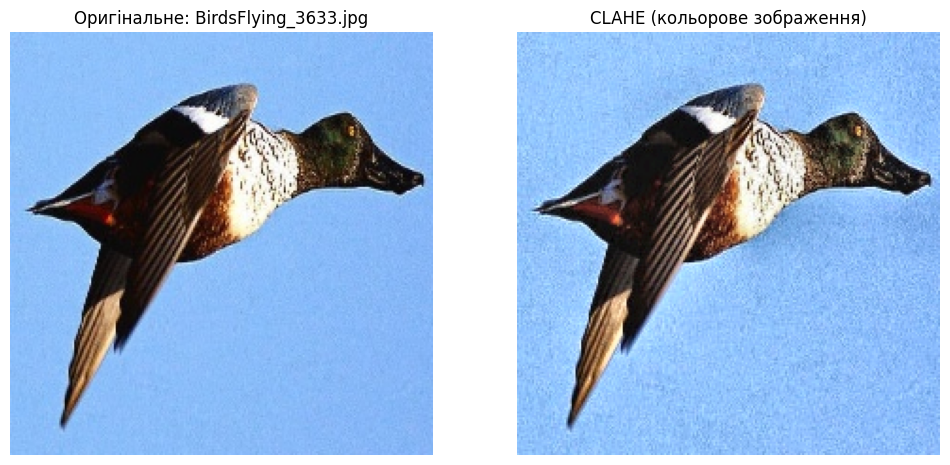

In [12]:
processor = ImageProcessor(images)

if images:
    img_name = images[0][0]

    processor.get_image_info(img_name)
    processor.plot_histogram(img_name)
    processor.enhance_contrast_gray(img_name, method="equalization")
    processor.enhance_contrast_gray(img_name, method="clahe")


    processor.enhance_contrast_color(img_name, method="equalization")
    processor.enhance_contrast_color(img_name, method="clahe")

In [13]:
class ImageFilter:
    def __init__(self, images):
        """
        Клас для аналізу та обробки зображень.
        :param images: список кортежів (ім'я_файлу, зображення)
        """
        self.image_cache = {name: img for name, img in images}

    def apply_gaussian_blur(self, img_name, ksize=5):
        """Гаусове розмиття для зменшення шуму"""
        img = self.image_cache.get(img_name, None)
        if img is None:
            print(f"Помилка: неможливо знайти {img_name}")
            return

        blurred = cv2.GaussianBlur(img, (ksize, ksize), 0)
        self._show_images(img, blurred, "Гаусове розмиття")

    def apply_median_blur(self, img_name, ksize=5):
        """Медіанний фільтр для зменшення імпульсного шуму"""
        img = self.image_cache.get(img_name, None)
        if img is None:
            print(f"Помилка: неможливо знайти {img_name}")
            return

        blurred = cv2.medianBlur(img, ksize)
        self._show_images(img, blurred, "Медіанний фільтр")

    def apply_bilateral_filter(self, img_name, d=9, sigmaColor=75, sigmaSpace=75):
        """Біквадратний фільтр для шумозниження з збереженням деталей"""
        img = self.image_cache.get(img_name, None)
        if img is None:
            print(f"Помилка: неможливо знайти {img_name}")
            return

        filtered = cv2.bilateralFilter(img, d, sigmaColor, sigmaSpace)
        self._show_images(img, filtered, "Біквадратний фільтр")

    def apply_sharpening(self, img_name):
        """Фільтр підвищення різкості"""
        img = self.image_cache.get(img_name, None)
        if img is None:
            print(f"Помилка: неможливо знайти {img_name}")
            return

        kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
        sharpened = cv2.filter2D(img, -1, kernel)
        self._show_images(img, sharpened, "Фільтр підвищення різкості")

    def apply_unsharp_masking(self, img_name, ksize=5, amount=1.5):
        """Метод Unsharp Masking для підвищення різкості"""
        img = self.image_cache.get(img_name, None)
        if img is None:
            print(f"Помилка: неможливо знайти {img_name}")
            return

        blurred = cv2.GaussianBlur(img, (ksize, ksize), 0)
        sharpened = cv2.addWeighted(img, 1 + amount, blurred, -amount, 0)
        self._show_images(img, sharpened, "Unsharp Masking")

    def _show_images(self, original, processed, title):
        """Допоміжна функція для візуалізації результату"""
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
        axes[0].set_title("Оригінальне")
        axes[0].axis("off")

        axes[1].imshow(cv2.cvtColor(processed, cv2.COLOR_BGR2RGB))
        axes[1].set_title(title)
        axes[1].axis("off")

        plt.show()

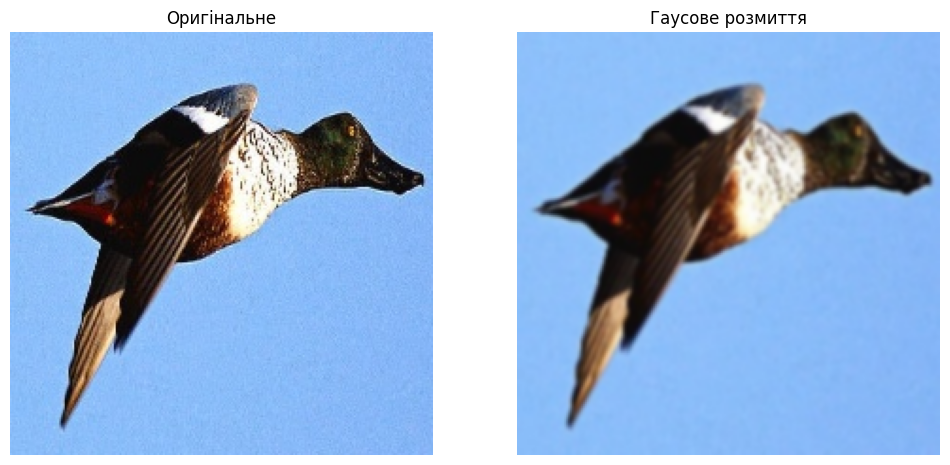

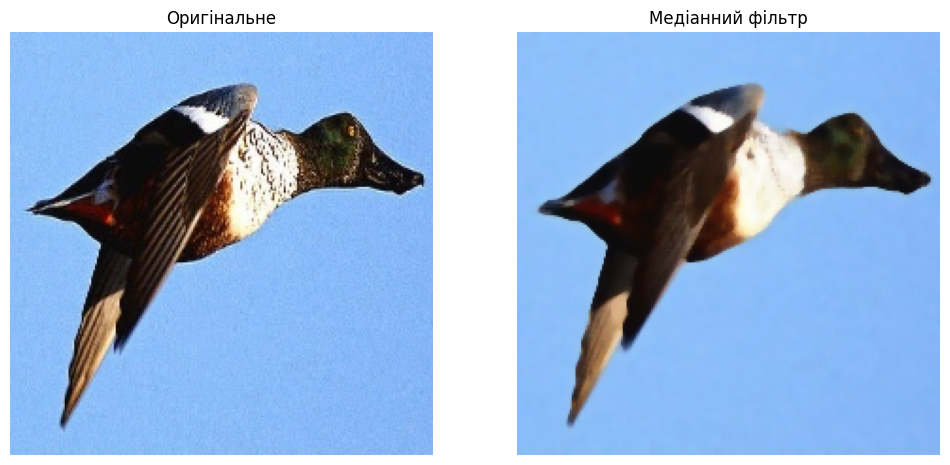

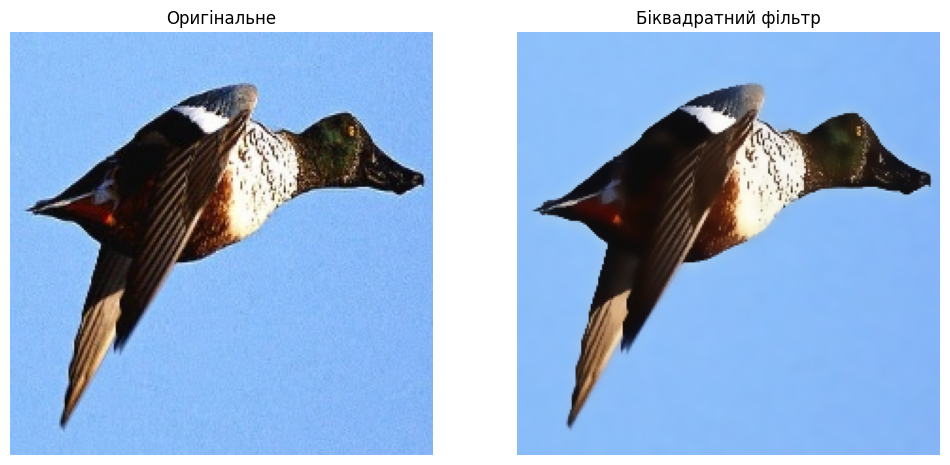

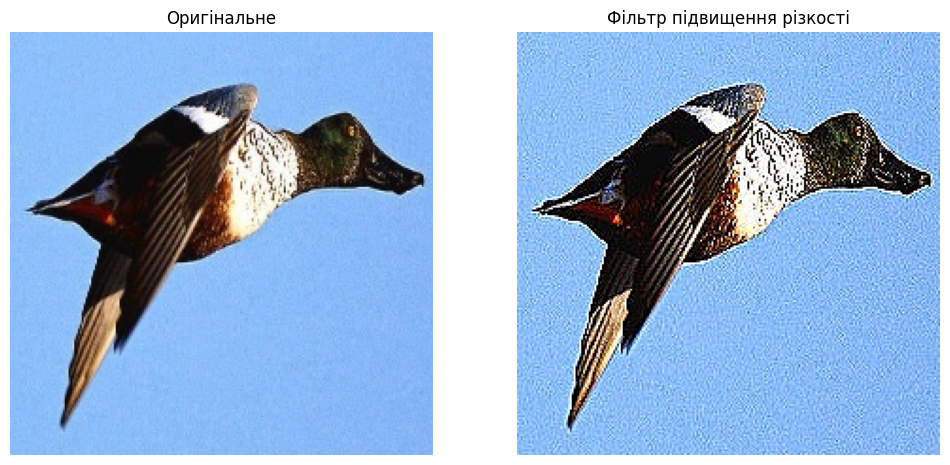

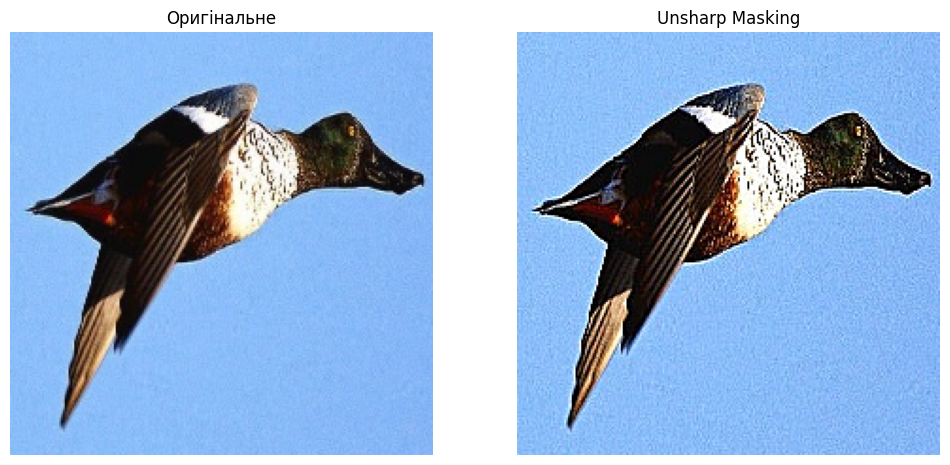

In [14]:
filter_processor = ImageFilter(images)

if images:
    img_name = images[0][0]

    filter_processor.apply_gaussian_blur(img_name)
    filter_processor.apply_median_blur(img_name)
    filter_processor.apply_bilateral_filter(img_name)

    filter_processor.apply_sharpening(img_name)
    filter_processor.apply_unsharp_masking(img_name)

In [28]:
class ImageSegmentation:
    def __init__(self, images):
        """
        Клас для аналізу та обробки зображень.
        :param images: список кортежів (ім'я_файлу, зображення)
        """
        self.image_cache = {name: img for name, img in images}

    def apply_threshold(self, img_name, threshold=127):
        """Звичайна порогова сегментація"""
        img = self.image_cache.get(img_name, None)
        if img is None:
            print(f"Помилка: неможливо знайти {img_name}")
            return

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, binary = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)
        self._show_images(gray, binary, "Звичайна порогова сегментація")

    def apply_otsu_threshold(self, img_name):
        """Метод Отсу для автоматичного вибору порогу"""
        img = self.image_cache.get(img_name, None)
        if img is None:
            print(f"Помилка: неможливо знайти {img_name}")
            return

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        self._show_images(gray, binary, "Метод Отсу")

    def apply_watershed(self, img_name):
        """Алгоритм Watershed для сегментації"""
        img = self.image_cache.get(img_name, None)
        if img is None:
            print(f"Помилка: неможливо знайти {img_name}")
            return

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        kernel = np.ones((3,3), np.uint8)
        opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)

        sure_bg = cv2.dilate(opening, kernel, iterations=3)
        dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
        _, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

        sure_fg = np.uint8(sure_fg)
        unknown = cv2.subtract(sure_bg, sure_fg)
        markers = cv2.connectedComponents(sure_fg)[1]
        markers = markers + 1
        markers[unknown == 255] = 0

        img_copy = img.copy()
        markers = cv2.watershed(img_copy, markers)
        img_copy[markers == -1] = [255, 0, 0]

        self._show_images(img, img_copy, "Watershed")

    def apply_grabcut(self, img_name, iter_count=5):
        """Алгоритм GrabCut для всієї області зображення"""
        img = self.image_cache.get(img_name, None)
        if img is None:
            print(f"Помилка: неможливо знайти {img_name}")
            return

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        _, binary = cv2.threshold(blurred, 127, 255, cv2.THRESH_BINARY)

        mask = np.full(img.shape[:2], cv2.GC_PR_FGD, dtype=np.uint8)
        mask[binary == 0] = cv2.GC_BGD

        bgdModel = np.zeros((1, 65), np.float64)
        fgdModel = np.zeros((1, 65), np.float64)

        cv2.grabCut(img, mask, None, bgdModel, fgdModel, iter_count, cv2.GC_INIT_WITH_MASK)

        mask2 = np.where((mask == cv2.GC_FGD) | (mask == cv2.GC_PR_FGD), 1, 0).astype("uint8")
        segmented = img * mask2[:, :, np.newaxis]

        self._show_images(img, segmented, "GrabCut (все фото)")

    def _show_images(self, original, processed, title):
        """Допоміжна функція для візуалізації результату"""
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
        axes[0].set_title("Оригінальне")
        axes[0].axis("off")

        axes[1].imshow(cv2.cvtColor(processed, cv2.COLOR_BGR2RGB))
        axes[1].set_title(title)
        axes[1].axis("off")

        plt.show()

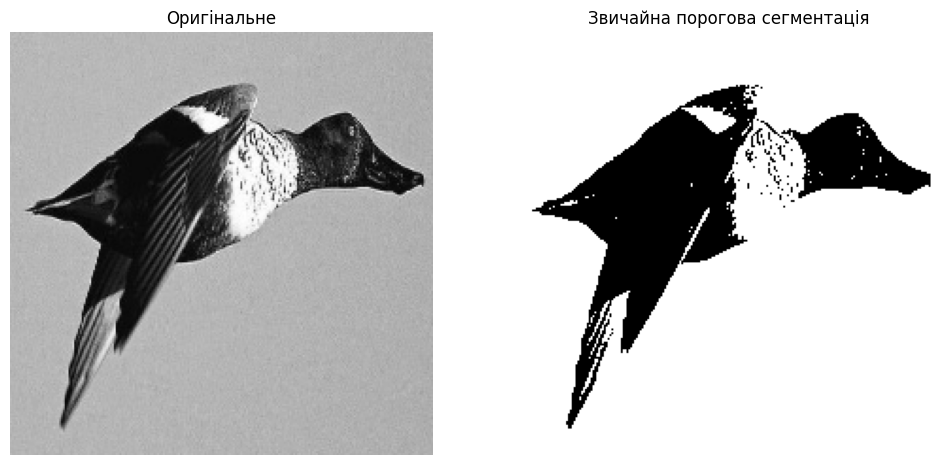

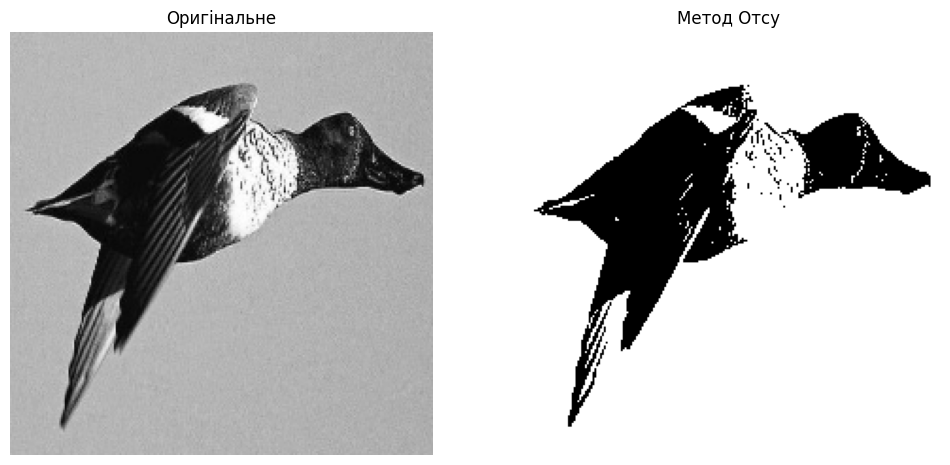

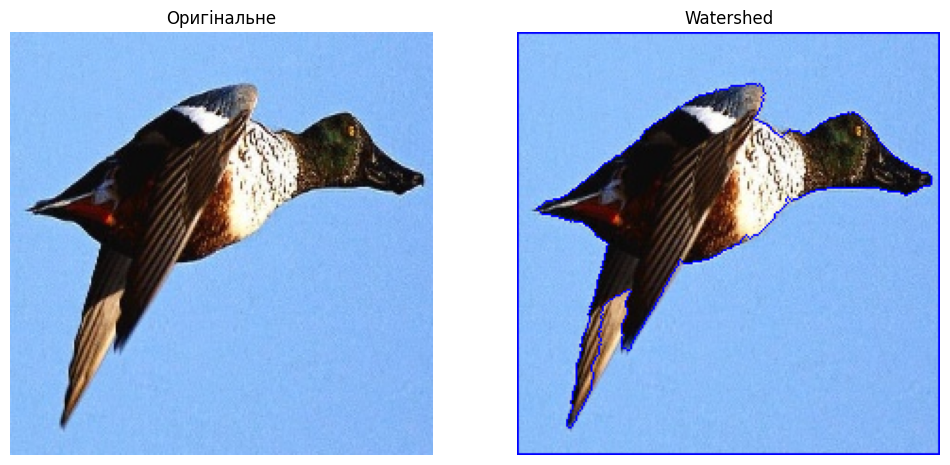

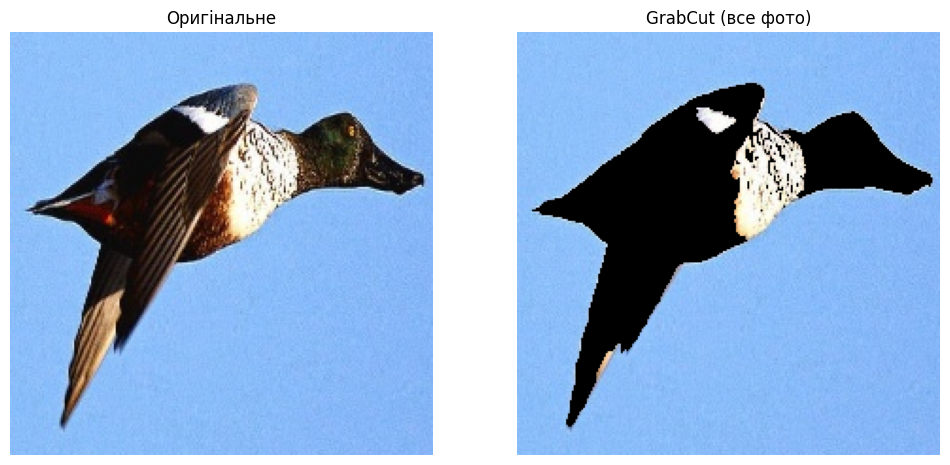

In [29]:
segmenter = ImageSegmentation(images)

if images:
    img_name = images[0][0]

    segmenter.apply_threshold(img_name)
    segmenter.apply_otsu_threshold(img_name)

    segmenter.apply_watershed(img_name)
    segmenter.apply_grabcut(img_name)